<a href="https://colab.research.google.com/github/Nouran-Khallaf/NLP_Visualisation/blob/main/NoteBooks/3_Text_Summariser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Summariser

## Tutorial: Building a Text Summarizer

### Introduction
This notebook demonstrates how to build a text summarizer using subset of Parliament  dataset. We will use the modeified clean_answer column for summarisation and evaluate the results.

**Extractive Summarization**:
Extractive summarization involves selecting key sentences or phrases from the original text and concatenating them to create a summary. The goal is to extract the most important information while maintaining the original context. This method does not generate new sentences but rather identifies and extracts the most relevant parts of the text.

**Abstractive Summarization**:
Abstractive summarization, on the other hand, involves generating new sentences that convey the most important information from the original text. This method goes beyond simply extracting key phrases and instead uses techniques like natural language generation to create a coherent and concise summary that may include paraphrasing and restructuring of information.

**Differences**:
- **Approach**: Extractive summarization selects and combines existing sentences, while abstractive summarization generates new sentences.
- **Output**: Extractive summarization tends to be more faithful to the original text, as it directly uses parts of it, whereas abstractive summarization can be more concise and coherent by generating new text.
- **Complexity**: Abstractive summarization is generally more complex and computationally intensive, as it requires understanding and generating natural language, whereas extractive summarization relies on identifying and selecting key parts of the text.

In [10]:
!pip install gdown
!pip install plotly
!pip install spacy
!pip install spacy-langdetect
!pip install langdetect
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54386 sha256=e78b3a517ef18c660dcf9b787d9aef68495aab10b892a24791995ee69b12a574
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [2]:
import gdown
url = 'https://drive.google.com/uc?id=1GSRJgJaRzb1OauKtHdwNoF4UnkKAt9cK'
output = 'Multilingual-Dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1GSRJgJaRzb1OauKtHdwNoF4UnkKAt9cK
To: /content/Multilingual-Dataset.zip
100%|██████████| 1.28M/1.28M [00:00<00:00, 87.4MB/s]


'Multilingual-Dataset.zip'

In [3]:
import zipfile
import os

if zipfile.is_zipfile(output):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Files extracted:")
    print(os.listdir('/content/'))
else:
    print("Downloaded file is not a zip file.")

Files extracted:
['.config', 'SourceTexts', '__MACOSX', 'Multilingual-Dataset.zip', 'sample_data']


In [4]:
import os
import shutil

# Define the source directory
source_dir = 'SourceTexts'

# List all files in the source directory
files = os.listdir(source_dir)

# Create a set to store unique language identifiers
languages = set()

# Identify unique languages from filenames
for file in files:
    language = file.split('.')[1]
    languages.add(language)

# Create folders for each language and move corresponding files
for language in languages:
    # Create the language folder if it doesn't exist
    language_dir = os.path.join(source_dir, language)
    os.makedirs(language_dir, exist_ok=True)

    # Move files into the language folder
    for file in files:
        if file.endswith(f'.{language}'):
            shutil.move(os.path.join(source_dir, file), os.path.join(language_dir, file))

print("Files have been organized into folders.")


Files have been organized into folders.


In [6]:
import os
import pandas as pd

def combine_files_to_dataframe(directory_path):
    # Initialize an empty list to store the data
    data = []

    # Loop through all files in the directory
    for file_name in os.listdir(directory_path):
        # Construct full file path
        file_path = os.path.join(directory_path, file_name)

        # Ensure it's a file
        if os.path.isfile(file_path):
            # Read the content of each file
            with open(file_path, 'r') as file:
                content = file.read()
                # Append the file name and content to the data list
                data.append({'Title': file_name, 'Content': content.strip()})

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)
    return df

# Specify the directory containing the files
directory_path = '/content/SourceTexts/english'

# Combine the files into a DataFrame
df = combine_files_to_dataframe(directory_path)

# Display the DataFrame
print(df)

# save the DataFrame to a CSV file
df.to_csv('combined_files.csv', index=False)

            Title                                            Content
0   M0046.english  Climate Conference in Bali concluded; opinions...
1   M0015.english  One year on, London remembers 7/7 victims\n\nF...
2   M0084.english  Tail from Air France jet recovered from Atlant...
3   M0024.english  European Union calls for release of British cr...
4   M0056.english  Wikinews investigates the reconstruction of Pi...
..            ...                                                ...
95  M0065.english  US government stops Haiti evacuations\n\nSunda...
96  M0075.english  Authenticity of new Abu Ghraib photos confirme...
97  M0071.english  USA leaving Abu Ghraib\n\nFriday, March 10, 20...
98  M0023.english  British sailors detained by Iran "to be tried ...
99  M0029.english  UK prepared to go 'into different phase' if sa...

[100 rows x 2 columns]


### 4. Summarization Function
Implement a simple text summarizer based on sentence extraction.

In [11]:
!pip install summa
!pip install seaborn mglearn
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from summa import summarizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 6.5 MB/s eta 0:00:00


In [12]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from summa import summarizer
import plotly.graph_objects as go

# Define the functions for cleaning and summarizing text
def clean_html(raw_html):
    """Remove HTML tags from a string"""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text()

def clean_text(text):
    """Remove unwanted text patterns and clean the text"""
    text = clean_html(text)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers if needed
    text = text.strip()  # Remove leading/trailing spaces
    return text

def summa_summarize(text, ratio=0.2):
    """Summarize text using the summa library"""
    summary = summarizer.summarize(text, ratio=ratio, language='english')
    return summary

# Load your DataFrame (Replace this with the path to your CSV file)
df = pd.read_csv('combined_files.csv')

# Apply preprocessing to the 'Content' column
df['clean_content'] = df['Content'].apply(clean_text)

# Apply summarization to the 'clean_content' column using summa
df['summary'] = df['clean_content'].apply(lambda x: summa_summarize(x, ratio=0.2))

# Visualize the data using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=['Title', 'Content', 'Clean Content', 'Summary'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df['Title'], df['Content'], df['clean_content'], df['summary']],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(
    title='Content Summarization',
    width=1000,
    height=600,
)

fig.show()

# Save the cleaned and summarized data to a CSV file if needed
df.to_csv('cleaned_and_summarized_contents.csv', index=False)


### 5. Apply Summarizer to Dataset

### 6. Save Summarized Data
Save the summarized data to a new CSV file.

In [ ]:
output_file = '/summarized_data.csv'
df.to_csv(output_file, index=False)
print(f"Summarized data saved to {output_file}")

Summarized data saved to /summarized_data.csv


### 7. Visualize Results
Visualize the length of original texts vs. summaries.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

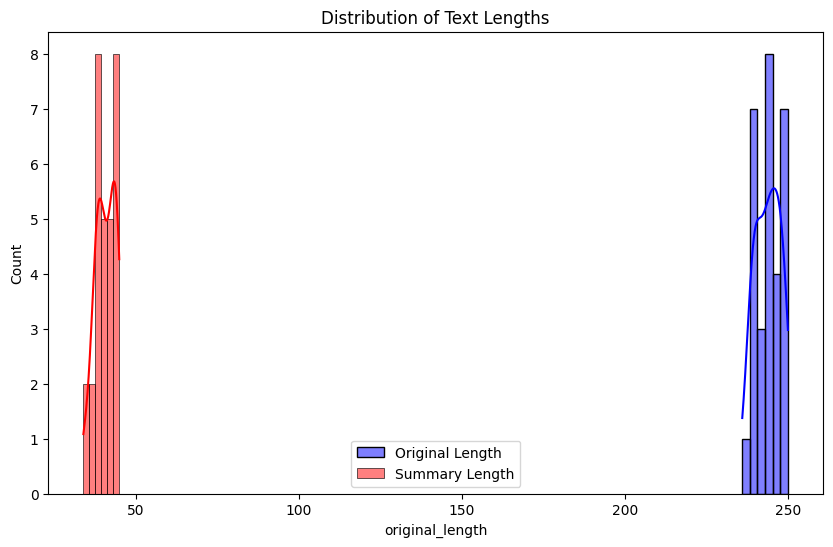

In [ ]:
df['original_length'] = df['clean_content'].apply(lambda x: len(x.split()))
df['summary_length'] = df['summary'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['original_length'], kde=True, color='blue', label='Original Length')
sns.histplot(df['summary_length'], kde=True, color='red', label='Summary Length')
plt.legend()
plt.title('Distribution of Text Lengths')
plt.show()

In [ ]:
import plotly.express as px
# Visualize the data using Plotly
fig = px.bar(df, x='Title', y=['original_length', 'summary_length'],
             labels={'value': 'Length', 'Title': 'Title'},
             title='Comparison of Original and Summarized Content Length',
             barmode='group')

fig.show()

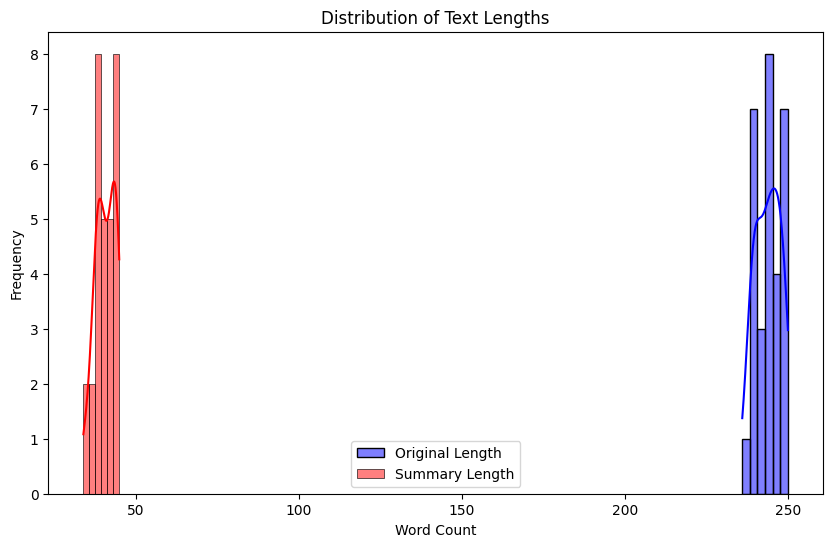

In [ ]:

# Histogram of Text Lengths using Matplotlib and Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df['original_length'], kde=True, color='blue', label='Original Length')
sns.histplot(df['summary_length'], kde=True, color='red', label='Summary Length')
plt.legend()
plt.title('Distribution of Text Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()





In [ ]:
# Scatter Plot of Original vs Summarized Lengths using Plotly
fig_scatter = px.scatter(df, x='original_length', y='summary_length',
                         labels={'original_length': 'Original Length', 'summary_length': 'Summary Length'},
                         title='Original vs Summarized Text Lengths')
fig_scatter.show()

# Bar Chart of Word Count Reduction using Plotly
df['reduction'] = df['original_length'] - df['summary_length']
fig_bar_reduction = px.bar(df, x='Title', y='reduction',
                           labels={'reduction': 'Reduction in Word Count', 'Title': 'Title'},
                           title='Reduction in Word Count per Title')
fig_bar_reduction.show()

In [ ]:
# Side-by-Side Comparison Table using Plotly
# Select a few entries for detailed comparison
comparison_df = df[['Title', 'clean_content', 'summary']].head(10)

fig_table = go.Figure(data=[go.Table(
    header=dict(values=['Title', 'Original Content', 'Summarized Content'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[comparison_df.Title, comparison_df.clean_content, comparison_df.summary],
               fill_color='lavender',
               align='left'))
])

fig_table.update_layout(
    title='Side-by-Side Comparison of Original and Summarized Content'
)

fig_table.show()

In [ ]:
from transformers import pipeline

# Load a summarization pipeline
summarizer = pipeline("summarization")

def summarize_text(text):
    # Use the summarizer to condense the text
    summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
    return summary[0]['summary_text']

# Apply summarization to the 'clean_answer' column
df['summary_transformer'] = df['clean_content'].apply(summarize_text)

print("\nFirst few rows of the summarized dataset:")
print(df[['clean_content', 'summary_transformer']].head())


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.



First few rows of the summarized dataset:
                                       clean_content  \
0  Haiti earthquake left material destruction, de...   
1  Tributes paid to the victims of the July   Lon...   
2  In September  it was announced that traffic me...   
3  On early December  began the proceedings of th...   
4  On January ,  a . magnitude earthquake struck ...   

                                 summary_transformer  
0   The lack of communication made it difficult t...  
1   Four years after the / London bombings, a . t...  
2   The reciprocal consensus' between China and T...  
3   Bali Roadmap established the target year of  ...  
4   On January ,  a . magnitude earthquake struck...  


https://developers.google.com/chart/interactive/docs/gallery/wordtree

In [ ]:
from IPython.core.display import display, HTML

# Combine titles and summaries into a single text block for the Word Tree
combined_text = '. '.join(df['Title'] + ': ' + df['summary'])

# Debug: Print combined text to check formatting
print(combined_text[:1000])  # Print the first 1000 characters to check formatting


## HTML and JavaScript Code for Google Word Tree
word_tree_html = f"""
<!DOCTYPE html>
<html>
  <head>
    <script type="text/javascript" src="https://www.gstatic.com/charts/loader.js"></script>
    <script type="text/javascript">
      google.charts.load('current', {{packages:['wordtree']}});
      google.charts.setOnLoadCallback(drawChart);
      function drawChart() {{
        var data = google.visualization.arrayToDataTable([
          ['Phrases'],
          ["{combined_text}"]
        ]);

        var options = {{
          wordtree: {{
            format: 'implicit',
            type: 'double',
            word: 'the'
          }}
        }};

        var chart = new google.visualization.WordTree(document.getElementById('wordtree_basic'));
        chart.draw(data, options);
      }}
    </script>
  </head>
  <body>
    <div id="wordtree_basic" style="width: 100%; height: 600px;"></div>
  </body>
</html>
"""


M006.C.250:  The lack of communication made it difficult to rescue people, who were underneath rubble . Hospitals had collapsed, raising fears that the injured wouldn't be able to receive treatment . The government of Haiti put an end to efforts to find any rescue. M001.A.250:  Four years after the / London bombings, a . tonne stainless steel plaque with the names of the victims has been unveiled in Hyde Park . Al Qaeda has claimed responsibility for the attacks, but police are unsure of its exact role in the. M009.B.250:  The reciprocal consensus' between China and Taiwan became cracked in many sporting events . In September it was announced that the torch of  Olympics will not cross Taiwan due to the political disputes with China . On April ,  the Olympic torch arrived in. M004.B.250:  Bali Roadmap established the target year of  and scope for a post-climate change agreement . Al Gore expressed the view that the US and China had to make more efforts to protect the environment against

In [ ]:
### Step 3: Display the Visualization in Colab
display(HTML(word_tree_html))

In [ ]:
import ipywidgets as widgets
# Combine titles and summaries into a single text block for the Word Tree
combined_text = '. '.join(df['Title'] + ': ' + df['summary'])

# Debug: Print combined text to check formatting
print(combined_text[:1000])  # Print the first 1000 characters to check formatting

# Function to generate the HTML and JavaScript for the Word Tree
def generate_word_tree_html(search_word):
    return f"""
    <!DOCTYPE html>
    <html>
      <head>
        <script type="text/javascript" src="https://www.gstatic.com/charts/loader.js"></script>
        <script type="text/javascript">
          google.charts.load('current', {{packages:['wordtree']}});
          google.charts.setOnLoadCallback(drawChart);
          function drawChart() {{
            var data = google.visualization.arrayToDataTable([
              ['Phrases'],
              ["{combined_text}"]
            ]);

            var options = {{
              wordtree: {{
                format: 'implicit',
                type: 'double',
                word: '{search_word}'
              }}
            }};

            var chart = new google.visualization.WordTree(document.getElementById('wordtree_basic'));
            chart.draw(data, options);
          }}
        </script>
      </head>
      <body>
        <div id="wordtree_basic" style="width: 100%; height: 600px;"></div>
      </body>
    </html>
    """

# Create an input widget
search_word_input = widgets.Text(
    value='the',
    placeholder='Enter a search word',
    description='Search word:',
    disabled=False
)

# Function to display the Word Tree
def display_word_tree(change):
    search_word = search_word_input.value
    word_tree_html = generate_word_tree_html(search_word)
    display(HTML(word_tree_html))

# Attach the function to the input widget
search_word_input.observe(display_word_tree, names='value')

# Display the input widget
display(search_word_input)

# Initial display of the Word Tree
display_word_tree(None)


M006.C.250:  The lack of communication made it difficult to rescue people, who were underneath rubble . Hospitals had collapsed, raising fears that the injured wouldn't be able to receive treatment . The government of Haiti put an end to efforts to find any rescue. M001.A.250:  Four years after the / London bombings, a . tonne stainless steel plaque with the names of the victims has been unveiled in Hyde Park . Al Qaeda has claimed responsibility for the attacks, but police are unsure of its exact role in the. M009.B.250:  The reciprocal consensus' between China and Taiwan became cracked in many sporting events . In September it was announced that the torch of  Olympics will not cross Taiwan due to the political disputes with China . On April ,  the Olympic torch arrived in. M004.B.250:  Bali Roadmap established the target year of  and scope for a post-climate change agreement . Al Gore expressed the view that the US and China had to make more efforts to protect the environment against

Text(value='the', description='Search word:', placeholder='Enter a search word')

In [ ]:
!pip install networkx matplotlib spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 17.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


       Entity Label
0       Haiti   GPE
1  Four years  DATE
2      London   GPE
3   Hyde Park   LOC
4    Al Qaeda   ORG


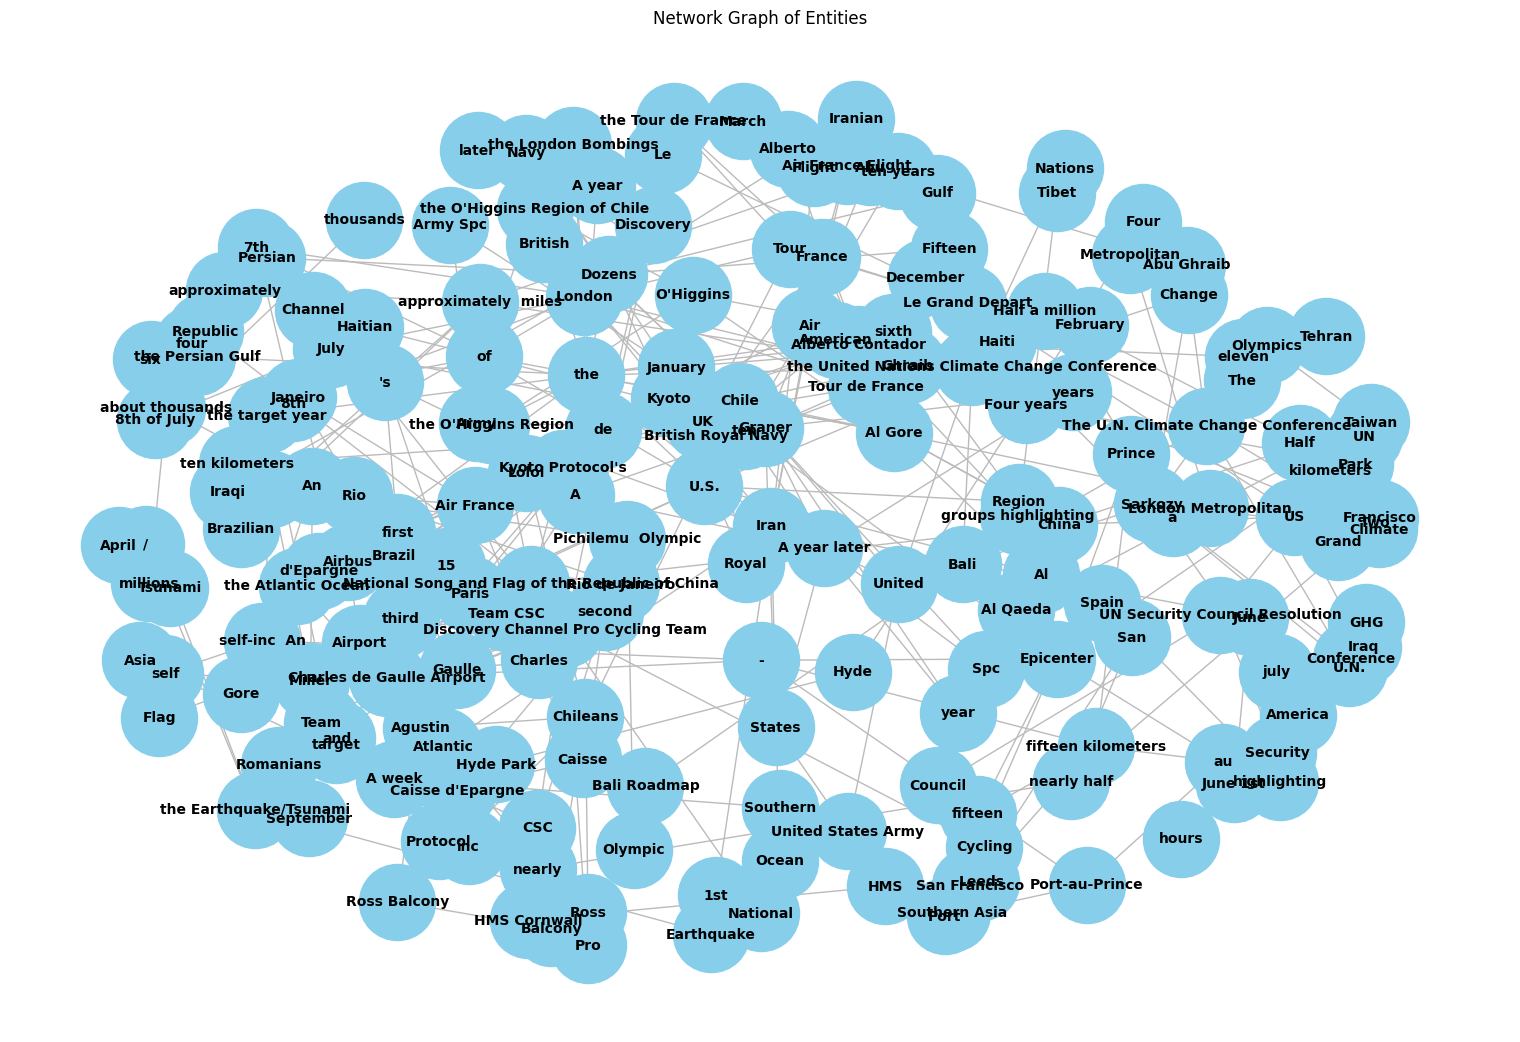

In [ ]:

import pandas as pd
import re
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# Load Spacy model
nlp = spacy.load("en_core_web_sm")



# Combine all summaries into a single text block for analysis
combined_text = ' '.join(df['summary'])

# Process text with Spacy
doc = nlp(combined_text)

# Extract entities
entities = [(ent.text, ent.label_) for ent in doc.ents]

# Create a DataFrame for entities
entities_df = pd.DataFrame(entities, columns=['Entity', 'Label'])

# Show the first few rows of entities_df
print(entities_df.head())

# Create a network graph
G = nx.Graph()

# Add nodes and edges
for entity in doc.ents:
    G.add_node(entity.text, label=entity.label_)
    for token in entity.root.head.subtree:
        if token != entity.root and token.ent_type_:
            G.add_edge(entity.text, token.text)

# Draw the network graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="#BBBBBB")
plt.title('Network Graph of Entities')
plt.show()







In [ ]:
# Combine all summaries into a single text block for analysis
combined_text = ' '.join(df['summary'])

# Process text with Spacy
doc = nlp(combined_text)

# Create a network graph
G = nx.Graph()

# Add nodes and edges based on entities and POS tags
for token in doc:
    if token.ent_type_:
        # Add POS tag as a node attribute
        G.add_node(token.text, label=token.ent_type_, POS=token.pos_)
        for child in token.children:
            if child.ent_type_:
                G.add_edge(token.text, child.text)

# Generate positions for the nodes
pos = nx.spring_layout(G, k=0.5)

# Assign positions to the nodes in the graph
for node in G.nodes:
    G.nodes[node]['pos'] = pos[node]

# Extract edge traces for visualization
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Extract node traces for visualization
node_x = []
node_y = []
node_text = []

for node in G.nodes:
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node} ({G.nodes[node]['label']})")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Create plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Network Graph of Entities and POS',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

fig.show()

In [ ]:

# Combine all summaries into a single text block for analysis
combined_text = ' '.join(df['summary'])

# Process text with Spacy
doc = nlp(combined_text)

# Define specific entities to highlight
highlight_entities = ["Haiti", "earthquake", "communication"]

# Create a network graph
G = nx.Graph()

# Add nodes and edges based on entities and POS tags
for token in doc:
    if token.ent_type_ or token.text in highlight_entities:
        # Add POS tag as a node attribute
        G.add_node(token.text, label=token.ent_type_, POS=token.pos_, color='red' if token.text in highlight_entities else 'skyblue')
        for child in token.children:
            if child.ent_type_ or child.text in highlight_entities:
                G.add_edge(token.text, child.text)

# Generate positions for the nodes
pos = nx.spring_layout(G, k=0.5)

# Assign positions to the nodes in the graph
for node in G.nodes:
    G.nodes[node]['pos'] = pos[node]

# Extract edge traces for visualization
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Extract node traces for visualization
node_x = []
node_y = []
node_text = []
node_color = []

for node in G.nodes:
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node} ({G.nodes[node]['label']})")
    node_color.append(G.nodes[node]['color'])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        color=node_color,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Create plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Network Graph of Entities and POS with Highlights',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

fig.show()

2. Show Network Graph for Specific Words

In [ ]:
import pandas as pd
import re
import spacy
import networkx as nx
import plotly.graph_objects as go

# Load Spacy model
nlp = spacy.load("en_core_web_sm")

# Combine all summaries into a single text block for analysis
combined_text = ' '.join(df['summary'])

# Process text with Spacy
doc = nlp(combined_text)

# Create a network graph
G = nx.Graph()

# Add nodes and edges based on specific words and their connections
specific_words = ['government', 'people','Qaeda']

for token in doc:
    if token.text in specific_words:
        G.add_node(token.text, label=token.pos_)
        for child in token.children:
            G.add_node(child.text, label=child.pos_)
            G.add_edge(token.text, child.text)

# Generate positions for the nodes
pos = nx.spring_layout(G, k=0.5)

# Assign positions to the nodes in the graph
for node in G.nodes:
    G.nodes[node]['pos'] = pos[node]

# Extract edge traces for visualization
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Extract node traces for visualization
node_x = []
node_y = []
node_text = []

for node in G.nodes:
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node} ({G.nodes[node]['label']})")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Create plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Network Graph for Specific Words',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

fig.show()


### Explanation:
1. **Data Preparation**:
   - The `clean_html` function removes HTML tags.
   - The `clean_text` function removes extra spaces, standalone numbers, and trims leading/trailing spaces.
   - The `summa_summarize` function summarizes the cleaned text.

2. **Entity Extraction**:
   - Use Spacy to process the combined text and extract entities.

3. **Build Graph**:
   - Create a network graph using `networkx`.
   - Add nodes for each entity and edges to show relationships.

4. **Visualize**:
   - Use `matplotlib` to visualize the network graph.

In [ ]:

import pandas as pd
import re
import spacy
import networkx as nx
import plotly.graph_objects as go

# Load Spacy model
nlp = spacy.load("en_core_web_sm")

# Combine all summaries into a single text block for analysis
combined_text = ' '.join(df['summary'])

# Process text with Spacy
doc = nlp(combined_text)

# Create a network graph
G = nx.Graph()

# Add nodes and edges based on entities and POS tags
highlight_entity = 'PERSON'  # Change to the entity type you want to highlight

for token in doc:
    if token.ent_type_:
        # Add POS tag as a node attribute
        G.add_node(token.text, label=token.ent_type_, POS=token.pos_)
        for child in token.children:
            if child.ent_type_:
                G.add_edge(token.text, child.text)

# Generate positions for the nodes
pos = nx.spring_layout(G, k=0.5)

# Assign positions to the nodes in the graph
for node in G.nodes:
    G.nodes[node]['pos'] = pos[node]

# Extract edge traces for visualization
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Extract node traces for visualization
node_x = []
node_y = []
node_text = []
node_color = []
node_size = []

for node in G.nodes:
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node} ({G.nodes[node]['label']})")
    if G.nodes[node]['label'] == highlight_entity:
        node_color.append('red')
        node_size.append(20)
    else:
        node_color.append('skyblue')
        node_size.append(10)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    hoverinfo='text',
    marker=dict(
        color=node_color,
        size=node_size,
        line=dict(width=2),
        showscale=True,
        colorscale='YlGnBu',
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        )))

# Create plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Network Graph of Entities with Highlighted Entities',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

fig.show()





In [ ]:
import pandas as pd
import re
import spacy
import networkx as nx
import plotly.graph_objects as go
from collections import Counter
import ipywidgets as widgets
from IPython.display import display

# Load Spacy model
nlp = spacy.load("en_core_web_sm")


# Combine all summaries into a single text block for analysis
combined_text = ' '.join(df['summary'])

# Process text with Spacy
doc = nlp(combined_text)

# Create a network graph
G = nx.Graph()

# Add nodes and edges based on entities and POS tags
highlight_entity = 'PERSON'  # Change to the entity type you want to highlight

for token in doc:
    if token.ent_type_:
        # Add POS tag as a node attribute
        G.add_node(token.text, label=token.ent_type_, POS=token.pos_)
        for child in token.children:
            if child.ent_type_:
                G.add_edge(token.text, child.text)

# Generate positions for the nodes
pos = nx.spring_layout(G, k=0.3)

# Assign positions to the nodes in the graph
for node in G.nodes:
    G.nodes[node]['pos'] = pos[node]

# Extract edge traces for visualization
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Extract node traces for visualization
node_x = []
node_y = []
node_text = []
node_color = []
node_size = []

for node in G.nodes:
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node} ({G.nodes[node]['label']})")
    degree = G.degree[node]
    if G.nodes[node]['label'] == highlight_entity:
        node_color.append('red')
        node_size.append(15 + degree * 2)
    else:
        node_color.append(degree)
        node_size.append(10 + degree * 2)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    hoverinfo='text',
    marker=dict(
        color=node_color,
        size=node_size,
        colorscale='Viridis',
        colorbar=dict(
            thickness=15,
            title='Node Degree',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)),
    textfont=dict(
        size=12,
        color='black'
    ))

# Create plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Enhanced Interactive Network Graph of Entities with Highlighted Entities',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

fig.show()

# Word Search Widget
def word_search_callback(b):
    search_word = word_search_input.value.lower()
    if not search_word:
        return

    # Find contexts for the search word
    word_contexts = []
    for token in doc:
        if token.text.lower() == search_word:
            for child in token.children:
                word_contexts.append(child.text.lower())
            for ancestor in token.ancestors:
                word_contexts.append(ancestor.text.lower())

    # Count word frequencies before and after the search word
    word_counts = Counter(word_contexts)
    most_common_words = word_counts.most_common(10)

    if most_common_words:
        words, counts = zip(*most_common_words)
    else:
        words, counts = [], []

    # Create bar chart for most common words around the search word
    bar_chart = go.Figure([go.Bar(x=words, y=counts)])
    bar_chart.update_layout(title=f"Most Frequent Words Around '{search_word}'",
                            xaxis_title="Words",
                            yaxis_title="Frequency")
    bar_chart.show()

# Create text input and button widgets
word_search_input = widgets.Text(
    value='',
    placeholder='Enter a search word',
    description='Search word:',
    disabled=False
)
word_search_button = widgets.Button(
    description='Search',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to search for the word'
)

# Set up the button click event
word_search_button.on_click(word_search_callback)

# Display the widgets
display(word_search_input)
display(word_search_button)


Text(value='', description='Search word:', placeholder='Enter a search word')

Button(description='Search', style=ButtonStyle(), tooltip='Click to search for the word')

In [ ]:
import pandas as pd
import re
import spacy
import networkx as nx
import plotly.graph_objects as go
from collections import Counter
import ipywidgets as widgets
from IPython.display import display

# Load Spacy model
nlp = spacy.load("en_core_web_sm")

# Combine all summaries into a single text block for analysis
combined_text = ' '.join(df['summary'])

# Process text with Spacy
doc = nlp(combined_text)

# Create a network graph
G = nx.Graph()

# Add nodes and edges based on entities and POS tags
highlight_entity = 'PERSON'  # Change to the entity type you want to highlight

for token in doc:
    if token.ent_type_:
        # Add POS tag as a node attribute
        G.add_node(token.text, label=token.ent_type_, POS=token.pos_)
        for child in token.children:
            if child.ent_type_:
                G.add_edge(token.text, child.text)

# Generate positions for the nodes
pos = nx.spring_layout(G, k=0.3)

# Assign positions to the nodes in the graph
for node in G.nodes:
    G.nodes[node]['pos'] = pos[node]

# Extract edge traces for visualization
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Extract node traces for visualization
node_x = []
node_y = []
node_text = []
node_color = []
node_size = []

for node in G.nodes:
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node} ({G.nodes[node]['label']})")
    degree = G.degree[node]
    if G.nodes[node]['label'] == highlight_entity:
        node_color.append('red')
        node_size.append(15 + degree * 2)
    else:
        node_color.append(degree)
        node_size.append(10 + degree * 2)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    hoverinfo='text',
    marker=dict(
        color=node_color,
        size=node_size,
        colorscale='Viridis',
        colorbar=dict(
            thickness=15,
            title='Node Degree',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)),
    textfont=dict(
        size=12,
        color='black'
    ))

# Create plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Enhanced Interactive Network Graph of Entities with Highlighted Entities',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

fig.show()

# Word Search Widget
def word_search_callback(b):
    search_word = word_search_input.value.lower()
    if not search_word:
        return

    # Find contexts for the search word
    word_contexts = []
    for token in doc:
        if token.text.lower() == search_word:
            for child in token.children:
                word_contexts.append(child.text.lower())
            for ancestor in token.ancestors:
                word_contexts.append(ancestor.text.lower())

    # Count word frequencies before and after the search word
    word_counts = Counter(word_contexts)
    most_common_words = word_counts.most_common(10)

    if most_common_words:
        words, counts = zip(*most_common_words)
    else:
        words, counts = [], []

    # Create a network graph for the search word
    search_graph = nx.Graph()
    search_graph.add_node(search_word, size=40)

    for word, count in most_common_words:
        search_graph.add_node(word, size=20 + count*2)
        search_graph.add_edge(search_word, word, weight=count)

    pos = nx.spring_layout(search_graph)

    edge_x = []
    edge_y = []

    for edge in search_graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_text = []
    node_size = []

    for node in search_graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)
        node_size.append(search_graph.nodes[node]['size'])

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition='top center',
        hoverinfo='text',
        marker=dict(
            size=node_size,
            colorscale='YlGnBu',
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)),
        textfont=dict(
            size=12,
            color='black'
        ))

    search_fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Network Graph for "{search_word}"',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper")],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)))

    search_fig.show()

# Create text input and button widgets
word_search_input = widgets.Text(
    value='',
    placeholder='Enter a search word',
    description='Search word:',
    disabled=False
)
word_search_button = widgets.Button(
    description='Search',
    disabled=False,
    button_style='success',
    tooltip='Click to search for the word'
)

# Set up the button click event
word_search_button.on_click(word_search_callback)

# Display the widgets
display(word_search_input)
display(word_search_button)


Text(value='', description='Search word:', placeholder='Enter a search word')

Button(button_style='success', description='Search', style=ButtonStyle(), tooltip='Click to search for the wor…

In [ ]:
import pandas as pd
import re
import spacy
import networkx as nx
import plotly.graph_objects as go
from collections import Counter
import ipywidgets as widgets
from IPython.display import display

# Load Spacy model
nlp = spacy.load("en_core_web_sm")


# Combine all summaries into a single text block for analysis
combined_text = ' '.join(df['summary'])

# Process text with Spacy
doc = nlp(combined_text)

# Create a network graph
G = nx.Graph()

# Add nodes and edges based on entities and POS tags
highlight_entity = 'PERSON'  # Change to the entity type you want to highlight

for token in doc:
    if token.ent_type_:
        # Add POS tag as a node attribute
        G.add_node(token.text, label=token.ent_type_, POS=token.pos_)
        for child in token.children:
            if child.ent_type_:
                G.add_edge(token.text, child.text)

# Generate positions for the nodes
pos = nx.spring_layout(G, k=0.3)

# Assign positions to the nodes in the graph
for node in G.nodes:
    G.nodes[node]['pos'] = pos[node]

# Extract edge traces for visualization
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Extract node traces for visualization
node_x = []
node_y = []
node_text = []
node_color = []
node_size = []

for node in G.nodes:
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node} ({G.nodes[node]['label']})")
    degree = G.degree[node]
    if G.nodes[node]['label'] == highlight_entity:
        node_color.append('red')
        node_size.append(15 + degree * 2)
    else:
        node_color.append(degree)
        node_size.append(10 + degree * 2)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    hoverinfo='text',
    marker=dict(
        color=node_color,
        size=node_size,
        colorscale='Viridis',
        colorbar=dict(
            thickness=15,
            title='Node Degree',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)),
    textfont=dict(
        size=12,
        color='black'
    ))

# Create plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Enhanced Interactive Network Graph of Entities with Highlighted Entities',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

fig.show()

# Word Search Widget
def word_search_callback(b):
    search_word = word_search_input.value.lower()
    if not search_word:
        return

    # Find contexts for the search word
    word_contexts = []
    for token in doc:
        if token.text.lower() == search_word:
            for child in token.children:
                word_contexts.append(child.text.lower())
            for ancestor in token.ancestors:
                word_contexts.append(ancestor.text.lower())

    # Count word frequencies before and after the search word
    word_counts = Counter(word_contexts)
    most_common_words = word_counts.most_common(10)

    if most_common_words:
        words, counts = zip(*most_common_words)
    else:
        words, counts = [], []

    # Create a network graph for the search word
    search_graph = nx.Graph()
    search_graph.add_node(search_word, size=40)

    for word, count in most_common_words:
        search_graph.add_node(word, size=20 + count*2)
        search_graph.add_edge(search_word, word, weight=count)

    pos = nx.spring_layout(search_graph, weight='weight')

    edge_x = []
    edge_y = []

    for edge in search_graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=[search_graph.edges[edge]['weight'] for edge in search_graph.edges()],
                  color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_text = []
    node_size = []

    for node in search_graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)
        node_size.append(search_graph.nodes[node]['size'])

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition='top center',
        hoverinfo='text',
        marker=dict(
            size=node_size,
            colorscale='YlGnBu',
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)),
        textfont=dict(
            size=12,
            color='black'
        ))

    search_fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Network Graph for "{search_word}"',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper")],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)))

    search_fig.show()

# Create text input and button widgets
word_search_input = widgets.Text(
    value='',
    placeholder='Enter a search word',
    description='Search word:',
    disabled=False
)
word_search_button = widgets.Button(
    description='Search',
    disabled=False,
    button_style='success',
    tooltip='Click to search for the word'
)

# Set up the button click event
word_search_button.on_click(word_search_callback)

# Display the widgets
display(word_search_input)
display(word_search_button)


Text(value='', description='Search word:', placeholder='Enter a search word')

Button(button_style='success', description='Search', style=ButtonStyle(), tooltip='Click to search for the wor…

ValueError: 
    Invalid value of type 'builtins.list' received for the 'width' property of scatter.line
        Received value: [3, 3, 3, 3, 2, 2, 2, 1, 1, 1]

    The 'width' property is a number and may be specified as:
      - An int or float in the interval [0, inf]

In [ ]:
!pip install pyvis

In [ ]:
import pandas as pd
import re
import spacy
import networkx as nx
from collections import Counter
import ipywidgets as widgets
from IPython.display import display, IFrame
from pyvis.network import Network

# Load Spacy model
nlp = spacy.load("en_core_web_sm")




# Combine all summaries into a single text block for analysis
combined_text = ' '.join(df['summary'])

# Process text with Spacy
doc = nlp(combined_text)

# Word Search Widget
def word_search_callback(b):
    search_word = word_search_input.value.lower()
    if not search_word:
        return

    # Find contexts for the search word
    word_contexts = []
    for token in doc:
        if token.text.lower() == search_word:
            for child in token.children:
                word_contexts.append(child.text.lower())
            for ancestor in token.ancestors:
                word_contexts.append(ancestor.text.lower())

    # Count word frequencies before and after the search word
    word_counts = Counter(word_contexts)
    most_common_words = word_counts.most_common(10)

    if most_common_words:
        words, counts = zip(*most_common_words)
    else:
        words, counts = [], []

    # Debug: Print the most common words and counts
    print("Most Common Words and Counts:", list(zip(words, counts)))

    # Create a network graph for the search word
    search_graph = nx.Graph()
    search_graph.add_node(search_word, size=60)

    for word, count in most_common_words:
        search_graph.add_node(word, size=20 + count*2)
        search_graph.add_edge(search_word, word, weight=count)

    # Debug: Print nodes and edges
    print("Nodes:", search_graph.nodes(data=True))
    print("Edges:", search_graph.edges(data=True))

    # Create interactive network graph using pyvis
    net = Network(notebook=True, height='750px', width='100%', cdn_resources='in_line')

    # Add the main node
    net.add_node(search_word, label=search_word, title=search_word, color='gray', size=60, font={'size': 32, 'face': 'Arial'})

    # Add nodes and edges
    for word, count in most_common_words:
        node_color = 'blue'
        node_size = 30 + count * 5
        font_size = max(6, int(node_size / 2))
        edge_length = 1 / count  # Inversely proportional to frequency
        net.add_node(word, label=word, title=word, color=node_color, size=node_size, font={'size': font_size, 'face': 'Arial'})
        net.add_edge(search_word, word, value=count, title=f'Weight: {count}', color='grey', length=edge_length)

    net.show("network_graph.html")

    display(IFrame('network_graph.html', width=750, height=750))

# Create text input and button widgets
word_search_input = widgets.Text(
    value='',
    placeholder='Enter a search word',
    description='Search word:',
    disabled=False
)
word_search_button = widgets.Button(
    description='Search',
    disabled=False,
    button_style='success',
    tooltip='Click to search for the word'
)

# Set up the button click event
word_search_button.on_click(word_search_callback)

# Display the widgets
display(word_search_input)
display(word_search_button)


Text(value='', description='Search word:', placeholder='Enter a search word')

Button(button_style='success', description='Search', style=ButtonStyle(), tooltip='Click to search for the wor…

Most Common Words and Counts: [('tour', 3), ('de', 3), ('of', 3), ('air', 3), ('to', 2), ('due', 2), ('flight', 2), ('the', 1), ('depart', 1), ('strength', 1)]
Nodes: [('france', {'size': 60}), ('tour', {'size': 26}), ('de', {'size': 26}), ('of', {'size': 26}), ('air', {'size': 26}), ('to', {'size': 24}), ('due', {'size': 24}), ('flight', {'size': 24}), ('the', {'size': 22}), ('depart', {'size': 22}), ('strength', {'size': 22})]
Edges: [('france', 'tour', {'weight': 3}), ('france', 'de', {'weight': 3}), ('france', 'of', {'weight': 3}), ('france', 'air', {'weight': 3}), ('france', 'to', {'weight': 2}), ('france', 'due', {'weight': 2}), ('france', 'flight', {'weight': 2}), ('france', 'the', {'weight': 1}), ('france', 'depart', {'weight': 1}), ('france', 'strength', {'weight': 1})]
network_graph.html


### Explanation
1. **Node Size and Color**:
   - Highlighted entities (e.g., `PERSON`) are colored red and have a larger size.
   - Other nodes are colored sky blue and have a smaller size.

2. **Edge Styling**:
   - Edges have a thicker line width for better visibility.

3. **Interactive Features**:
   - Nodes and edges have hover information enabled.
   - A color scale is added to show node connections.

4. **Layout and Styling**:
   - The layout is adjusted for better readability with a clean background and margins.
   - The title is more prominent, and the color bar provides context for the node connections.
